<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/unstructured_nougat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PDF Preprocessing and Documents Creations

https://github.com/Unstructured-IO


https://github.com/facebookresearch/nougat

Installing required libraries

In [1]:
!pip install torch huggingface_hub python-dotenv transformers sentence-transformers pymupdf langchain langchain-community langchain-huggingface chromadb tqdm unidecode gradio bitsandbytes seaborn unstructured[pdf]

In [2]:
!pip install -q pymupdf python-Levenshtein nltk
!pip install -q git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!apt-get install poppler-utils tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  poppler-utils tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 5,002 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 5,002 kB in 0s (12.1 MB/s)
Selecting previously unselected package poppl

In [4]:
import os
import torch
from huggingface_hub import login
from dotenv import load_dotenv
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from sentence_transformers import SentenceTransformer
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import time
from tqdm import tqdm
import re
import gradio as gr
from unidecode import unidecode
import random

In [5]:
import nltk

print(nltk.__version__)  # confirm you see 3.9.1, otherwise restart session

nltk.download("punkt")

3.9.1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Environment Setup
Here we detect if this notebook is being executed in a **Google Colab environment** or a **local system**, seting up the environment accordingly loading keys and downloading required files.

Note that, in order to speed up the execution, we download also the elements.pkl file to avoid some expensive processing (*about 30 minute*).

In [14]:
PDF_NAME = "IR Slides v1.0.pdf"
running_on_colab = False

try:
    import gdown
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("Running in Google Colab. Using userdata to get HF_TOKEN.")
    running_on_colab = True

except ModuleNotFoundError:
    load_dotenv()
    HF_TOKEN = os.getenv('HF_TOKEN')
    print("Not running in Google Colab. Using load_dotenv to get HF_TOKEN.")

file_path = PDF_NAME
# save locally from https://drive.google.com/file/d/1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY/view?usp=drive_link
gdown.download(id="1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY", output=PDF_NAME, quiet=False)

# download of pickled elements to speed up the execution
gdown.download(id="17eXYgmiTL9-f9F5vIT5j7QffHIu_QwuN", output="elements.pkl", quiet=False)

# Logs into Hugging Face using the token
login(token=HF_TOKEN)

Running in Google Colab. Using userdata to get HF_TOKEN.


Downloading...
From: https://drive.google.com/uc?id=1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY
To: /content/IR Slides v1.0.pdf
100%|██████████| 85.5M/85.5M [00:00<00:00, 204MB/s]
Downloading...
From: https://drive.google.com/uc?id=17eXYgmiTL9-f9F5vIT5j7QffHIu_QwuN
To: /content/elements.pkl
100%|██████████| 1.53M/1.53M [00:00<00:00, 99.5MB/s]


## PDF Partitioning with Unstructured
Processes the PDF `"IR Slides v1.0.pdf"` using the `partition` function to extract structured elements.

We decide to apply the **high-resolution strategy** because is highly sensitive, it is recommended if you want obtain precise classifications for document elements. Adopting this strategy we are able to use the document layout to gain additional information about document elements, in particular we are able to recognize:
- **Titles** and **Text** (we use them as it is)
- **Formulas** (we further process them)
- **Images** (will be removed)
- **Page Breaks** (fundamental to handle formulas and create chuncks)


In [18]:
from unstructured.partition.auto import partition

file_name = "IR Slides v1.0.pdf"
title = "Information Retrival"

load_elements_from_pickle = True
elements = []

if load_elements_from_pickle:

  # Loading the pickled elements.
  # Set load_elements_from_pickle = True above, if you would like to load
  # those elements insted of running the Unstructure's partitioning.

  import pickle
  # load elements.pkl in elements
  with open('elements.pkl', 'rb') as f:
      elements = pickle.load(f)

else:

  elements = partition(
      filename=file_name,
      strategy="hi_res",
      skip_infer_table_types=[],
      include_page_breaks=True,
  )

print("Number of recognized elements: " + str(len(elements)) + " in file " + file_name)

Number of recognized elements: 4486 in file IR Slides v1.0.pdf


Storing the elements in a pickle file.
Snippet of code executed if needed.

In [10]:
# save elements on a binary file
import pickle

# to uncomment, now is commented cause we are downloading the pickled elements
'''with open('elements.pkl', 'wb') as f:
    pickle.dump(elements, f)'''

"with open('elements.pkl', 'wb') as f:\n    pickle.dump(elements, f)"

## Filtering and Analyzing Extracted Elements

Here we build a **dataframe**, creating pairs of **Type** and **Value**, using the elements extracted from the PDF file.

Then we print all the different element's Type recognized.



In [19]:
type_value_elements = []

for i in range(len(elements)):
  pair = [type(elements[i]), elements[i].text]
  type_value_elements.append(pair)

import pandas as pd
df_elements = pd.DataFrame(type_value_elements, columns=['Type', 'Value'])

# print all the different possible Type in the dataframe
print(df_elements['Type'].unique())

[<class 'unstructured.documents.elements.Title'>
 <class 'unstructured.documents.elements.EmailAddress'>
 <class 'unstructured.documents.elements.PageBreak'>
 <class 'unstructured.documents.elements.ListItem'>
 <class 'unstructured.documents.elements.NarrativeText'>
 <class 'unstructured.documents.elements.Image'>
 <class 'unstructured.documents.elements.FigureCaption'>
 <class 'unstructured.documents.elements.Table'>
 <class 'unstructured.documents.elements.Text'>
 <class 'unstructured.documents.elements.Footer'>
 <class 'unstructured.documents.elements.Formula'>
 <class 'unstructured.documents.elements.Header'>]


Now we clean the dataframe filtering out all the useless elements:
- **Images** (for them we have a text extracted with OCR technique, but not very useful for the language model due to a loss of meaning)
- **Email Addresses**
- **Table** (similarly to the images they lost some meaning as they are extracted)
- **Footers** and **Headers**


In [24]:
from unstructured.documents.elements import Image, EmailAddress, FigureCaption, Table, Footer, Header, PageBreak

# print df number of rows
print("Number of actual elements: " + str(len(df_elements)))

# drop all the rows with unuseful Types
df_elements = df_elements[df_elements['Type'] != Image]
df_elements = df_elements[df_elements['Type'] != EmailAddress]
df_elements = df_elements[df_elements['Type'] != Table]
df_elements = df_elements[df_elements['Type'] != Footer]
df_elements = df_elements[df_elements['Type'] != Header]
df_elements = df_elements.drop(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')].index)

# print df number of rows
print("Number of elements after filtering: " + str(len(df_elements)))

# reassign the dataframe index
df_elements = df_elements.reset_index(drop=True)

# print all the different possible Type in the dataframe
print(df_elements['Type'].unique())


Number of actual elements: 4030
Number of elements after filtering: 4030
[<class 'unstructured.documents.elements.Title'>
 <class 'unstructured.documents.elements.PageBreak'>
 <class 'unstructured.documents.elements.ListItem'>
 <class 'unstructured.documents.elements.NarrativeText'>
 <class 'unstructured.documents.elements.FigureCaption'>
 <class 'unstructured.documents.elements.Text'>
 <class 'unstructured.documents.elements.Formula'>]


Check if there are some empty-valued elements, that are not Page Breaks, in the dataframe.

In [25]:
# print rows of df_elements with bith Type != PageBreak and Value empty
print(len(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')]))

if len(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')]) > 0:
  df_elements = df_elements.drop(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')].index)

0


## Formulas Detection
Here we identify and track pages containing formulas in the PDF.

- `page_with_formula_indexes`: stores page indexes with formulas.
- `number_of_formulas_per_page`: tracks the count of formulas per page.
- `locations_with_formula_at_page`: stores locations of formulas in the DataFrame by page.


In [29]:
from unstructured.documents.elements import Formula, PageBreak

page_with_formula_indexes = []

# dictionary to store the number of formula for each page
number_of_formulas_per_page = {}
locations_with_formula_at_page = {}

index = 0  # first page -> index = 0

# iterate over df_elements
for i in range(len(df_elements)):
  if df_elements.iloc[i]['Type'] == PageBreak:
    index += 1
  if df_elements.iloc[i]['Type'] == Formula: #or df_elements.iloc[i]['Type'] == Image:
    # saving in dictionary the dataframe locations with formula/image for that page
    if index not in locations_with_formula_at_page:
      locations_with_formula_at_page[index] = [i]
    else:
      locations_with_formula_at_page[index].append(i)
    # saving in dictionary the number of formula/image for that page
    if index not in number_of_formulas_per_page:
      number_of_formulas_per_page[index] = 1
    else:
      number_of_formulas_per_page[index] += 1
    if index not in page_with_formula_indexes:
      page_with_formula_indexes.append(index)

print("Pages with formulas indexes")
print(page_with_formula_indexes)
print("Number of pages with at least one formula: " + str(len(page_with_formula_indexes)))

Pages with formulas indexes
[89, 94, 95, 96, 97, 136, 142, 157, 160, 165, 168, 180, 181, 182, 184, 187, 189, 193, 194, 203, 208, 210]
Number of pages with at least one formula: 22


## Loading Nougat Model and Processor
This code initializes the `Nougat` model and its processor for handling vision-to-text tasks.


In [18]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

# Load the Nougat model and processor from the hub
processor = AutoProcessor.from_pretrained("facebook/nougat-small")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-small")

preprocessor_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    896,
    672
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "qkv_bias": true,
  "transformers_version": "4.48.0.dev0",
  "use_absolute_embeddings": false,
  "window_size": 7
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_final_layer_norm":

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

In [19]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

The following block of code is taken from the example at this link from `Nougat` GitHub: https://github.com/inuwamobarak/nougat/blob/main/Nougat_Inference_to_read_scientific_PDFs.ipynb

In [20]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

## Rasterizing PDF Pages for Formula Processing
Now we extract and process specific pages containing formulas from a PDF.

In particular the processing is made in order to obtain the rasterized **images of specific pages** of the PDF file.


22


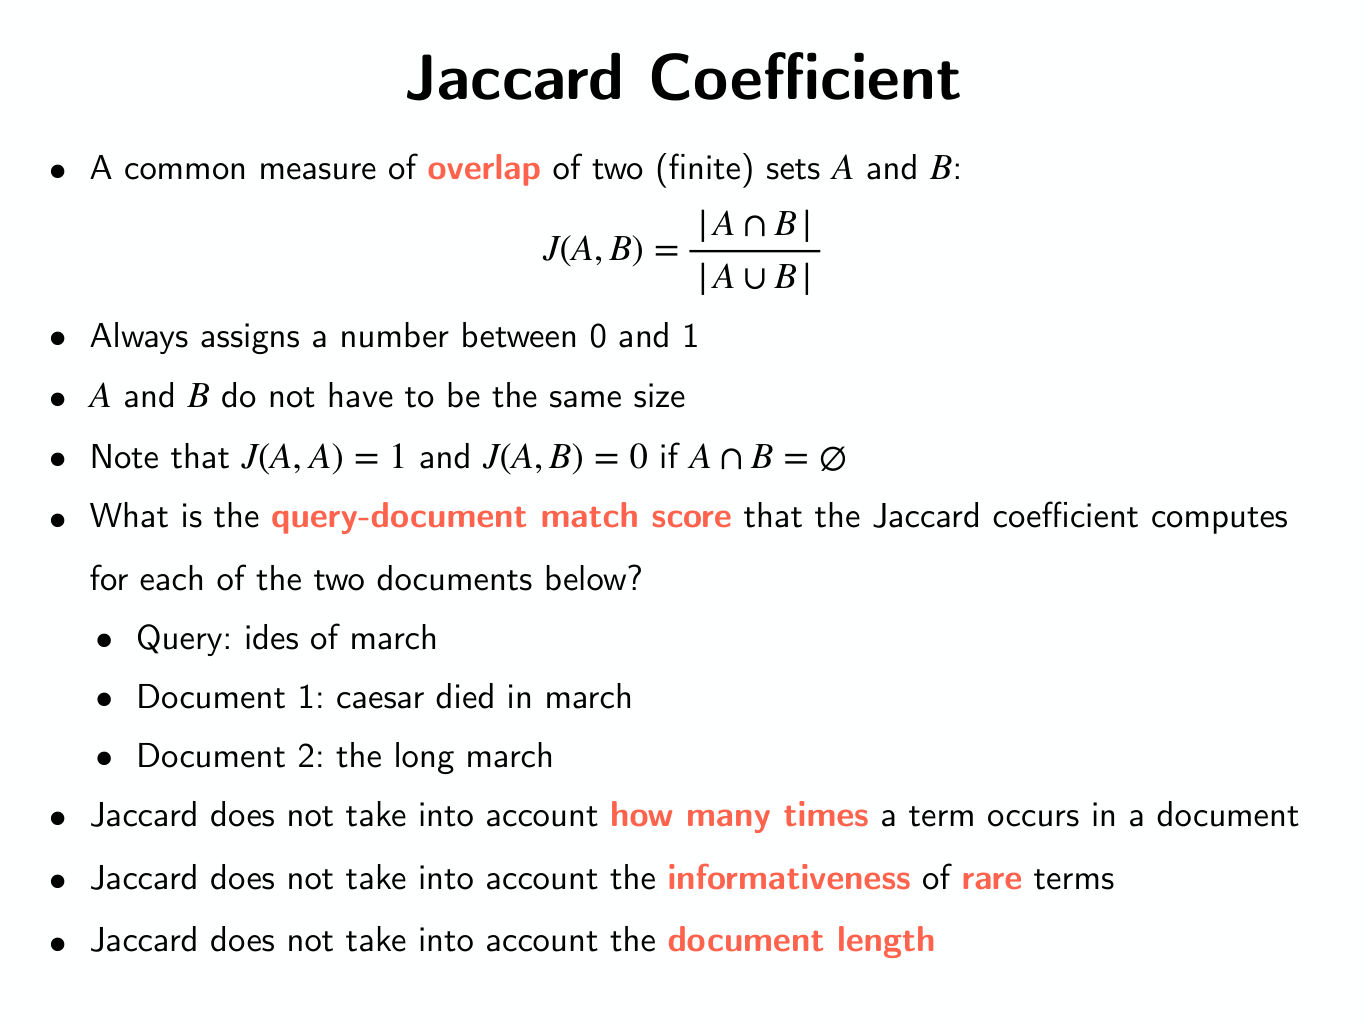

In [21]:
from huggingface_hub import hf_hub_download
from typing import Optional, List
import io
import fitz
from pathlib import Path
from PIL import Image


images = rasterize_paper(pdf=file_name, return_pil=True, pages=page_with_formula_indexes)

print("Number of processed pages: " + str(len(images)))

# Display the first image
image = Image.open(images[0])
image


The following block of code is taken from the example at this link from `Nougat` GitHub: https://github.com/inuwamobarak/nougat/blob/main/Nougat_Inference_to_read_scientific_PDFs.ipynb

In [22]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

## Generating Outputs from Processed Images
Once we obtained an image for each page containing at least a formula, we can generate text outputs from images using the `Nougat` model.

- `outputs` is the list to store generated text for each image
- The **image processing** converts images into tensor format using the `processor`.
- For the **text generation** the tensor is passed to the model's `generate` method.

Note that this block require a compatible GPU, for efficient processing, indicated by `device`.



In [23]:
outputs = []

for i in range(len(images)):

  image = Image.open(images[i])

  pixel_values = processor(images=image, return_tensors="pt").pixel_values

  outputs.append(
        model.generate(
        pixel_values.to(device),
        min_length=1,
        max_length=3584,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True,
        stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
    )
  )

22


<ipython-input-22-1f2d56ef631f>:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  return torch.var(self.values, 1) / self.values.shape[1]


22


This function extracts LaTeX formulas enclosed within `\[ \]` from a given text.

In [24]:
def formulas_extraction(latex_text):
    """
    Extracts all substrings that start with '\[' and end with '\]' and returns them as a list.
    """
    # The pattern looks for:
    #   - literal "\["
    #   - any characters, non-greedily (.*?)
    #   - literal "\]"
    pattern = r"(\\\[.*?\\\])"

    matches = re.findall(pattern, latex_text)

    return matches

In [33]:
# save outputs in a pickle file
import pickle
with open('outputs.pkl', 'wb') as f:
    pickle.dump(outputs, f)

# Post-Processing Generated Formulas
Now we are able to process the generated LaTeX formulas for each page and update the corresponding DataFrame entries.

- **Purpose:**
  - Ensures that the number of extracted formulas matches the expected count per page.
  - Handles cases where formulas are fewer or greater than expected.

- **Workflow:**
  1. **Formula Extraction:**
     - Decodes the generated text and extracts formulas using `formulas_extraction`.
  2. **Case Handling:**
     - **No Formulas:** if no formulas extracted by `Nougat` we can keep the formulas as extracted by `Unstructure`.
     - **Fewer Formulas:** concatenate formulas extracted by `Nougat` into a single string and update the first location in the DataFrame, marking others as `REMOVING_STR`.
     - **More Formulas:** concatenate and store in the first location, similar to fewer formulas.
     - **Matching Formulas:** update the DataFrame with extracted formulas directly.

Note that we give priority to `Nougat` formulas, if extracred, due to a more precise and correct representation.


In [26]:
from tkinter.constants import E
from unstructured.documents.elements import Title, NarrativeText, Image, Formula, PageBreak

cases_ok = 0
cases_not_improved = 0
cases_under_expected = 0
cases_over_expected = 0

REMOVING_STR = "LOC_TO_BE_REMOVED"

for i in range(len(outputs)):

  page_index = page_with_formula_indexes[i]

  generated = processor.batch_decode(outputs[i][0], skip_special_tokens=True)[0]
  generated = processor.post_process_generation(generated, fix_markdown=False)

  formulas = formulas_extraction(generated)

  if len(formulas) == 0:
    cases_not_improved += 1
    continue

  num_over_expected = number_of_formulas_per_page[page_index] - len(formulas)

  if num_over_expected < 0:

    cases_under_expected += 1

    # concatenate all elements in formulas in a unique string
    concatenated_formulas = " ".join(formulas)

    for j in range(number_of_formulas_per_page[page_index]):
      if j == 0:
        df_elements.at[locations_with_formula_at_page[page_index][j], 'Value'] = concatenated_formulas
      else:
        df_elements.at[locations_with_formula_at_page[page_index][j], 'Value'] = REMOVING_STR

  elif num_over_expected > 0:

    cases_over_expected += 1

    # concatenate all elements in formulas in a unique string
    concatenated_formulas = " ".join(formulas)

    for j in range(number_of_formulas_per_page[page_index]):
      if j == 0:
        df_elements.at[locations_with_formula_at_page[page_index][j], 'Value'] = concatenated_formulas
      else:
        df_elements.at[locations_with_formula_at_page[page_index][j], 'Value'] = REMOVING_STR

  else:
    cases_ok += 1
    for j in range(number_of_formulas_per_page[page_index]):
      df_elements.at[locations_with_formula_at_page[page_index][j], 'Value'] = formulas[j]

print("Cases ok: " + str(cases_ok))
print("Cases not improved: " + str(cases_not_improved))
print("Cases under expected: " + str(cases_under_expected))
print("Cases over expected: " + str(cases_over_expected))

Cases ok: 11
Cases not improved: 2
Cases under expected: 7
Cases over expected: 2


In [28]:
# print df row with value REMOVING_STR
print(df_elements[df_elements['Value'] == REMOVING_STR])

                                                   Type              Value
2512  <class 'unstructured.documents.elements.Formula'>  LOC_TO_BE_REMOVED
2563  <class 'unstructured.documents.elements.Formula'>  LOC_TO_BE_REMOVED
2569  <class 'unstructured.documents.elements.Formula'>  LOC_TO_BE_REMOVED


In [29]:
# drop df row with value REMOVING_STR
df_elements = df_elements[df_elements['Value'] != REMOVING_STR]

# reset index
df_elements = df_elements.reset_index(drop=True)

print(df_elements[df_elements['Value'] == REMOVING_STR])

Empty DataFrame
Columns: [Type, Value]
Index: []


In [27]:
from unstructured.documents.elements import Formula

# print df_elements for rows with Type Formula
print(df_elements[df_elements['Type'].isin([Formula])])

                                                   Type  \
963   <class 'unstructured.documents.elements.Formula'>   
1020  <class 'unstructured.documents.elements.Formula'>   
1024  <class 'unstructured.documents.elements.Formula'>   
1040  <class 'unstructured.documents.elements.Formula'>   
1046  <class 'unstructured.documents.elements.Formula'>   
1060  <class 'unstructured.documents.elements.Formula'>   
1957  <class 'unstructured.documents.elements.Formula'>   
2068  <class 'unstructured.documents.elements.Formula'>   
2299  <class 'unstructured.documents.elements.Formula'>   
2304  <class 'unstructured.documents.elements.Formula'>   
2334  <class 'unstructured.documents.elements.Formula'>   
2337  <class 'unstructured.documents.elements.Formula'>   
2374  <class 'unstructured.documents.elements.Formula'>   
2400  <class 'unstructured.documents.elements.Formula'>   
2505  <class 'unstructured.documents.elements.Formula'>   
2512  <class 'unstructured.documents.elements.Formula'> 

Here we clean up the `df_elements` DataFrame by removing consecutive duplicate rows while keeping the first occurrence.


In [30]:
print("Number of elements before removing adjacent duplicates: " + str(len(df_elements)))

# drop adjacent duplicates in the df_elements mantaining the first one
df_elements = df_elements.loc[df_elements.shift().ne(df_elements).any(axis=1)]

# reset index
df_elements = df_elements.reset_index(drop=True)

print("Number of elements after removing adjacent duplicates: " + str(len(df_elements)))

4027
3791


In [31]:
from unstructured.documents.elements import PageBreak

# count the number of rows with Type PageBreak
print(len(df_elements[df_elements['Type'] == PageBreak]))

322


In [52]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

def count_tokens(text):
  return len(word_tokenize(text))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Splitting Content into Tokenized Chunks
Here we divide the processed elements in `df_elements` into smaller text files, ensuring each file stays within a token limit.

**Chunk Creation:**
- Processes elements in `df_elements`:
  - Concatenates values until the token count exceeds `doc_tokens_threshold`.
  - Writes each chunk to a separate text file (`docX.txt`).
  - Tracks the token count of each chunk in `docs_len`.
- Handles `PageBreak` to reset and manage document boundaries.

Adjust `doc_tokens_threshold` to change the maximum token count per file.


In [72]:
import os

# create folder chunks if it doesn't exist
if not os.path.exists('chunks'):
    os.makedirs('chunks')
else:
    # delete all the files in the folder chunks
    for file in os.listdir('chunks'):
        os.remove(os.path.join('chunks', file))


block = ""
document = ""
doc_index = 0
doc_tokens_threshold = 250
docs_len = []

# iterating over df_elements
for i in range(len(df_elements)):


  if df_elements.at[i, 'Type'] != PageBreak:

    next_element = df_elements.at[i, 'Value'] + "\n"

    if count_tokens(block) + count_tokens(next_element) > doc_tokens_threshold:
        with open('chunks/doc' + str(doc_index) + '.txt', 'w') as f:
          f.write(block)

        docs_len.append(count_tokens(block))
        doc_index += 1
        block = ""

    block += next_element

  else: # if the type is a PageBreak or

    expected_num_tokens = count_tokens(document) + count_tokens(block)
    if expected_num_tokens > doc_tokens_threshold:

      with open('chunks/doc' + str(doc_index) + '.txt', 'w') as f:
        f.write(document)

      docs_len.append(count_tokens(document))
      doc_index += 1
      document = ""

    document += block
    block = ""

print("Number of chunks obtained: " + str(doc_index))

141


In [73]:
# print the max, the min and the avg of values in docs_len
print(len(docs_len))

print(max(docs_len))
print(min(docs_len))
print(sum(docs_len)/len(docs_len))

141
250
35
199.60992907801418
